<a href="https://colab.research.google.com/github/SergeySkopin/SergeyS_pet/blob/master/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import torch
from torch import nn
from torchvision import models, transforms
from torch.autograd import Variable
from torchvision.models import resnet50, ResNet50_Weights

**Preprocessing**

In [ ]:
#Загружаем свое изображение
image = Image.open("cat.jpg")
imshow(image)

FileNotFoundError: ignored

In [ ]:
norm_data = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   norm_data
])
display = transforms.Compose([transforms.Resize((224,224))])
tensor = preprocess(image)
pred = Variable((tensor.unsqueeze(0)), requires_grad=True)

**Define model**

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
f_ex = nn.Sequential(*list(model.children())[:-2])
classification = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))    
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

**Grad-CAM**

In [ ]:
def GradCAM(img, cl_sc, f_ex, classification):
    f_map = f_ex(img)
    _, N, H, W = f_map.size()
    c_score = classification(f_map)[0,cl_sc]
    grads = torch.autograd.grad(c_score, f_map) #Computes and returns the sum of gradients of outputs with respect to the inputs. 
    w = grads[0][0].mean(-1).mean(-1)
    gradcam = torch.matmul(w, f_map.view(N, H*W))
    gradcam = gradcam.view(H, W).cpu().detach().numpy()
    gradcam = np.maximum(gradcam, 0)
    
    return gradcam

**Visiualizing**

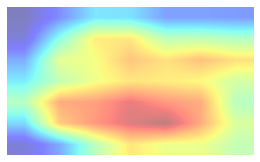

In [ ]:
prob, class_cl = torch.topk(nn.Softmax(dim=1)(model(pred)), 3) #Returns the k largest elements of the given input tensor along a given dimension.
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
gradcam = GradCAM(pred, int(class_cl[0][0]), f_ex, classification)
gradcam = Image.fromarray(gradcam)
gradcam = gradcam.resize(image.size, resample=Image.LINEAR)

#Plot our mask
plt.axis('off')
plt.imshow(np.array(gradcam), alpha=0.5, cmap='jet')

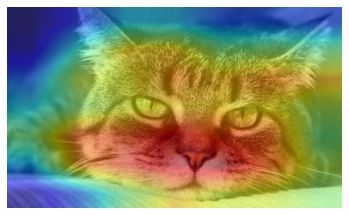

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.imshow(np.array(gradcam), alpha=0.5, cmap='jet')
plt.show()